In [27]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Load dataset

In [28]:
!pip install kaggle tensorflow

In [29]:
!kaggle datasets download -d alessiocorrado99/animals10

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
animals10.zip: Skipping, found more recently modified local copy (use --force to force download)


In [30]:
!unzip animals10.zip -d animals10

Streaming output truncated to the last 5000 lines.
  inflating: animals10/raw-img/ragno/OIP-MVQChNQpHiMZEVMPehrvoAHaE6.jpeg  
  inflating: animals10/raw-img/ragno/OIP-MVdIFDAFpNyK_XCpwkDIWgHaFj.jpeg  
  inflating: animals10/raw-img/ragno/OIP-MYY_8k5AHqMJwTCNXfH6rwHaFj.jpeg  
  inflating: animals10/raw-img/ragno/OIP-MZEVXuoMsATG8u_UuTQ6hAHaE8.jpeg  
  inflating: animals10/raw-img/ragno/OIP-MZg0tznDRE95AMfyuutuYAHaE6.jpeg  
  inflating: animals10/raw-img/ragno/OIP-M_r9DkR2X5gP0P5-z8wPYQHaE7.jpeg  
  inflating: animals10/raw-img/ragno/OIP-M_xDUSzjlF3-w9XHCm93cgHaFF.jpeg  
  inflating: animals10/raw-img/ragno/OIP-MbI4-bMyutRX3X382IAVcQAAAA.jpeg  
  inflating: animals10/raw-img/ragno/OIP-MbMksZdD7gomsC9fd6cpKgHaHJ.jpeg  
  inflating: animals10/raw-img/ragno/OIP-Md4AMcvjaHcivJqeW06wEwHaFW.jpeg  
  inflating: animals10/raw-img/ragno/OIP-MgCgailkT5XkO1XczzQCngHaLK.jpeg  
  inflating: animals10/raw-img/ragno/OIP-MgrKq05YHGXsgj1AmYIyJQHaE8.jpeg  
  inflating: animals10/raw-img/ragno/OIP-MhRGx7d8

# Split data

In [31]:
dataset_path = "animals10/raw-img"
output_folder = "animals_split"

In [32]:
import os

classes = os.listdir(dataset_path)
print(f"Classes: {classes}")

Classes: ['gallina', 'mucca', 'cavallo', 'ragno', 'farfalla', 'elefante', 'gatto', 'scoiattolo', 'cane', 'pecora']


In [33]:
!pip install split-folders

In [34]:
import splitfolders

splitfolders.ratio(
    dataset_path,
    output=output_folder,
    seed=42,
    ratio=(0.7, 0.1, 0.2)
)

print(f"Dataset split done.")

Copying files: 26179 files [00:06, 3877.79 files/s]

Dataset split done.


In [35]:
train_path = os.path.join(output_folder, "train")
val_path = os.path.join(output_folder, "val")
test_path = os.path.join(output_folder, "test")

def count_images(folder):
    return sum([len(files) for _, _, files in os.walk(folder)])

train_images = count_images(train_path)
val_images = count_images(val_path)
test_images = count_images(test_path)

print(f"Number of train images: {train_images}")
print(f"Number of validation images: {val_images}")
print(f"Number of test images: {test_images}")

Number of train images: 18322
Number of validation images: 2614
Number of test images: 5243


# Imports

In [36]:
import os
import pickle
import random
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from sklearn.preprocessing import label_binarize
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout

# functions

In [37]:
def plot_learning_curves(history, figsize=(12, 6), title='Learning Curves'):
    plt.figure(figsize=figsize)

    if 'accuracy' in history and 'val_accuracy' in history:
        plt.plot(history['accuracy'], label='Train Accuracy')
        plt.plot(history['val_accuracy'], label='Validation Accuracy')

    if 'loss' in history and 'val_loss' in history:
        plt.plot(history['loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Validation Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy / Loss')
    plt.legend()
    plt.title(title)
    plt.show()


def plot_confusion_matrix(y_true, y_pred, class_labels, figsize=(10, 8), cmap="Blues", title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap,
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.title(title)
    plt.ylabel("True Labels")
    plt.xlabel("Predicted Labels")
    plt.show()


def plot_roc_curves(y_true, y_pred, num_classes, figsize=(10, 8)):

    y_true_binarized = label_binarize(y_true, classes=np.arange(num_classes))
    roc_auc_scores = {}
    plt.figure(figsize=figsize)

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
        roc_auc_scores[f"Class {i}"] = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_scores[f"Class {i}"]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Classes')
    plt.legend()
    plt.show()

    return roc_auc_scores


def visualize_random_predictions(test_gen, y_pred_classes, num_samples=5):

    for i in range(num_samples):
        batch_index = random.randint(0, len(test_gen) - 1)
        batch = test_gen[batch_index]
        images, labels = batch[0], batch[1]

        image_index = random.randint(0, len(images) - 1)
        img = images[image_index]
        true_label = np.argmax(labels[image_index])
        pred_label = y_pred_classes[batch_index * test_gen.batch_size + image_index]

        plt.imshow(img)
        plt.title(f"True: {true_label}, Pred: {pred_label}")
        plt.axis('off')
        plt.show()


# Phase-1 (Model Designing)

batch_size=16 , learning_rate=0.0005
Train Accuracy: 0.90 , Test Accuracy: 0.72

---


batch_size=32 , learning_rate=0.001
Train Accuracy: 0.90 , Test Accuracy: 0.70

---


batch_size=64 , learning_rate=0.0001
Train Accuracy: 0.54 , Test Accuracy: 0.52

---


batch_size=128 , learning_rate=0.01
Train Accuracy: 0.18 , Test Accuracy: 0.18

---


best -> batch_size=16 , learning_rate=0.0005



Paths

In [ ]:
train_path = "animals_split/train"
val_path = "animals_split/val"
test_path = "animals_split/test"

Preprocessing

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255)
train_gen = datagen.flow_from_directory(train_path, target_size=(64, 64), batch_size=16, class_mode='categorical')
val_gen = datagen.flow_from_directory(val_path, target_size=(64, 64), batch_size=16, class_mode='categorical')
test_gen = datagen.flow_from_directory(test_path, target_size=(64, 64), batch_size=16, class_mode='categorical', shuffle=False)

Found 18322 images belonging to 10 classes.
Found 2614 images belonging to 10 classes.
Found 5243 images belonging to 10 classes.


CNN model

In [ ]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Number of parameters

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,292,682 (4.93 MB)

 Trainable params: 1,292,682 (4.93 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_gen, validation_data=val_gen, epochs=20)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1146/1146 ━━━━━━━━━━━━━━━━━━━━ 50s 33ms/step - accuracy: 0.1973 - loss: 2.1915 - val_accuracy: 0.2559 - val_loss: 2.0681
Epoch 2/20
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 66s 28ms/step - accuracy: 0.3076 - loss: 1.9756 - val_accuracy: 0.3818 - val_loss: 1.7682
Epoch 3/20
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 32s 28ms/step - accuracy: 0.4177 - loss: 1.6690 - val_accuracy: 0.4507 - val_loss: 1.5739
Epoch 4/20
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 34s 29ms/step - accuracy: 0.4922 - loss: 1.4361 - val_accuracy: 0.5520 - val_loss: 1.2950
Epoch 5/20
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 32s 28ms/step - accuracy: 0.5559 - loss: 1.2764 - val_accuracy: 0.5585 - val_loss: 1.2457
Epoch 6/20
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 42s 29ms/step - accuracy: 0.5789 - loss: 1.1904 - val_accuracy: 0.5872 - val_loss: 1.1694
Epoch 7/20
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 42s 29ms/step - accuracy: 0.6174 - loss: 1.0887 - val_accuracy: 0.6251 - val_loss: 1.1088
Epoch 8/20
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - accuracy: 0.6486 - loss: 1.01

Save model

In [ ]:
save_path = '/content/drive/MyDrive/project-4/Models/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

model.save(os.path.join(save_path, 'model_bs16_lr0005.h5'))

Save history

In [ ]:
save_path = '/content/drive/MyDrive/project-4/Models/'

history_path = os.path.join(save_path, 'history_bs16_lr0005.pkl')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)

Load model

In [ ]:
save_path = '/content/drive/MyDrive/project-4/Models/'
loaded_model = load_model(os.path.join(save_path, 'model_bs16_lr0005.h5'))

Load history

In [ ]:
with open(history_path, 'rb') as f:
    loaded_history = pickle.load(f)

Evaluate model

In [ ]:
train_loss, train_accuracy = loaded_model.evaluate(train_gen)
print(f"Train Accuracy: {train_accuracy:.2f}")

test_loss, test_accuracy = loaded_model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy:.2f}")

1146/1146 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.9030 - loss: 0.2923
Train Accuracy: 0.90
328/328 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.7125 - loss: 0.9040
Test Accuracy: 0.72


Generate prediction

In [ ]:
y_pred = loaded_model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

328/328 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step


Learning Curves

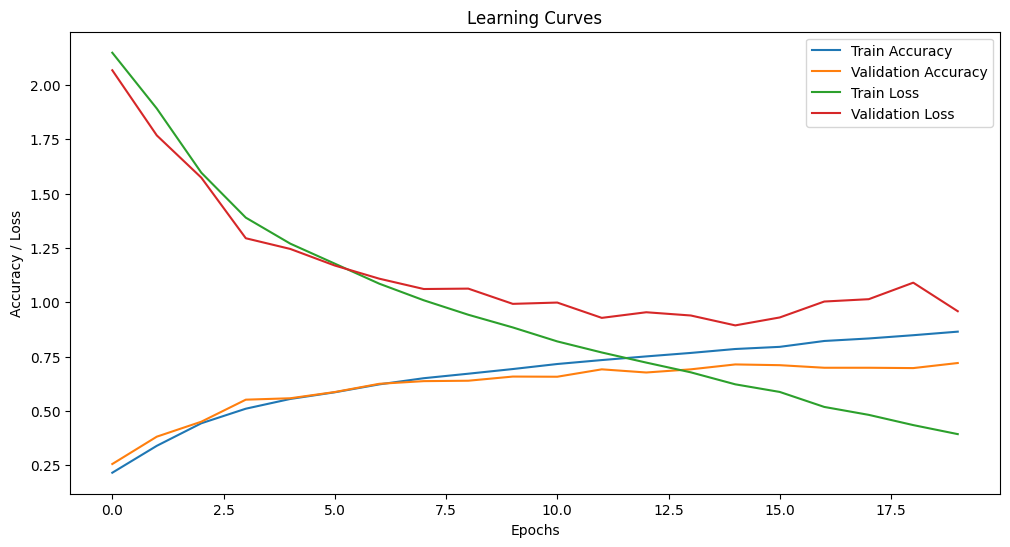

In [ ]:
plot_learning_curves(loaded_history)

Confusion matrix

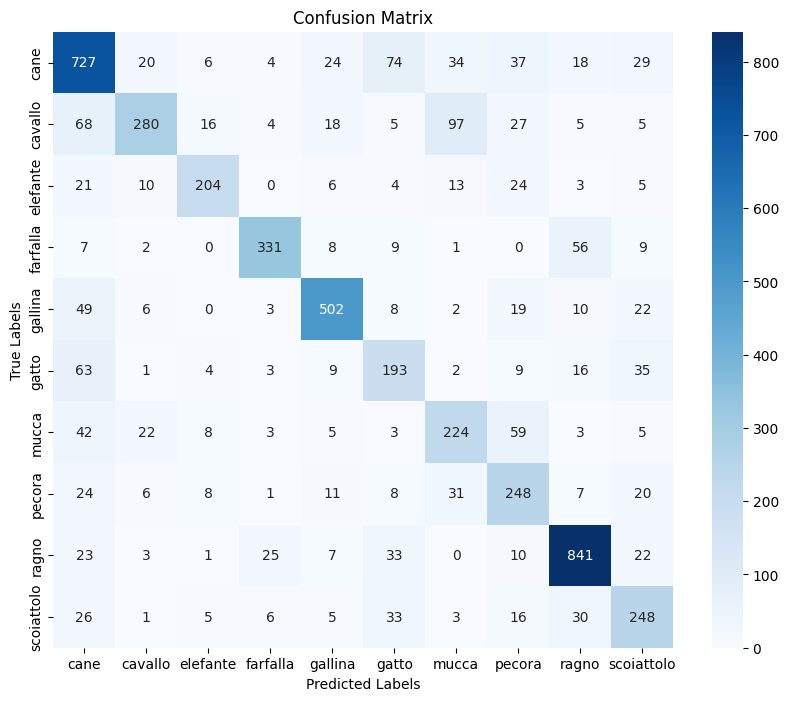

In [ ]:
class_labels = list(test_gen.class_indices.keys())
plot_confusion_matrix(y_true, y_pred_classes, class_labels)

ROC Curve

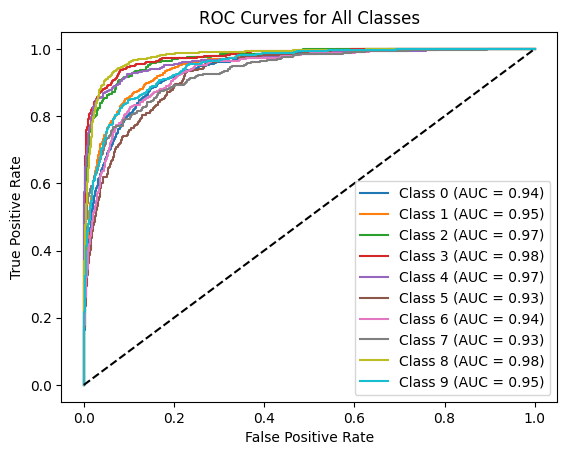

In [ ]:
num_classes = 10
roc_auc_scores = plot_roc_curves(y_true, y_pred, num_classes)
print(roc_auc_scores)

Precision , recall , f1-score

In [ ]:
print(classification_report(y_true, y_pred_classes, target_names=test_gen.class_indices.keys()))

              precision    recall  f1-score   support

        cane       0.69      0.75      0.72       973
     cavallo       0.80      0.53      0.64       525
    elefante       0.81      0.70      0.75       290
    farfalla       0.87      0.78      0.82       423
     gallina       0.84      0.81      0.83       621
       gatto       0.52      0.58      0.55       335
       mucca       0.55      0.60      0.57       374
      pecora       0.55      0.68      0.61       364
       ragno       0.85      0.87      0.86       965
  scoiattolo       0.62      0.66      0.64       373

    accuracy                           0.72      5243
   macro avg       0.71      0.70      0.70      5243
weighted avg       0.73      0.72      0.73      5243



Visualize

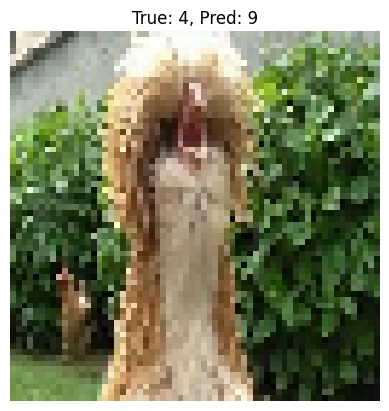

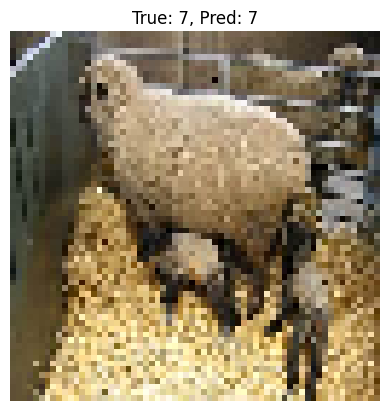

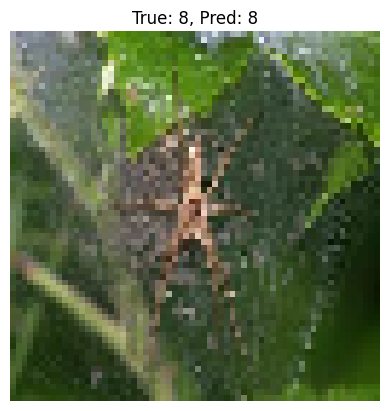

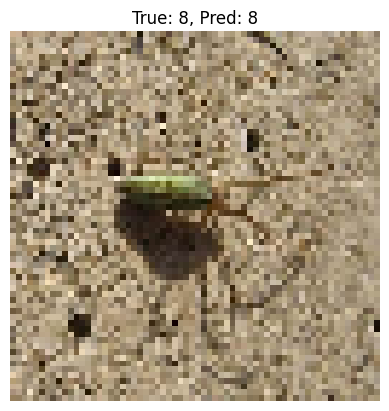

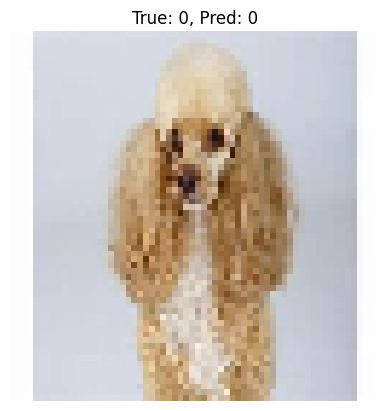

In [ ]:
visualize_random_predictions(test_gen, y_pred_classes, num_samples=5)

# Phase-2 (Parameter Limitation)

batch_size=16 , learning_rate=0.0005 , epochs=40
Train Accuracy: 0.87 , Test Accuracy: 0.73

---


batch_size=32 , learning_rate=0.001, epochs=40
Train Accuracy: 0.89 , Test Accuracy: 0.71

---


batch_size=64 , learning_rate=0.0001, epochs=40
Train Accuracy: 51 , Test Accuracy: 50

---


batch_size=128 , learning_rate=0.01, epochs=40
Train Accuracy: 0.19 , Test Accuracy: 0.19

---


best -> batch_size=16 , learning_rate=0.0005 , epochs=40



Paths

In [ ]:
train_path_2 = "animals_split/train"
val_path_2 = "animals_split/val"
test_path_2 = "animals_split/test"

Preprocessing

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255)
train_gen_2 = datagen.flow_from_directory(train_path_2, target_size=(64, 64), batch_size=16, class_mode='categorical')
val_gen_2 = datagen.flow_from_directory(val_path_2, target_size=(64, 64), batch_size=16, class_mode='categorical')
test_gen_2 = datagen.flow_from_directory(test_path_2, target_size=(64, 64), batch_size=16, class_mode='categorical', shuffle=False)

Found 18322 images belonging to 10 classes.
Found 2614 images belonging to 10 classes.
Found 5243 images belonging to 10 classes.


CNN model

In [ ]:
model_2 = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(16, activation='relu'),
    Dense(10, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Number of parameters

In [ ]:
model_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 392,634 (1.50 MB)

 Trainable params: 392,634 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_2 = model_2.fit(train_gen_2, validation_data=val_gen_2, epochs=40)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1146/1146 ━━━━━━━━━━━━━━━━━━━━ 47s 33ms/step - accuracy: 0.1950 - loss: 2.2011 - val_accuracy: 0.2142 - val_loss: 2.1548
Epoch 2/40
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 34s 30ms/step - accuracy: 0.2413 - loss: 2.0863 - val_accuracy: 0.3118 - val_loss: 1.9466
Epoch 3/40
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 38s 27ms/step - accuracy: 0.3346 - loss: 1.9099 - val_accuracy: 0.3757 - val_loss: 1.7731
Epoch 4/40
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 43s 29ms/step - accuracy: 0.3930 - loss: 1.7346 - val_accuracy: 0.4178 - val_loss: 1.6665
Epoch 5/40
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 35s 30ms/step - accuracy: 0.4480 - loss: 1.5787 - val_accuracy: 0.4763 - val_loss: 1.5146
Epoch 6/40
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 33s 29ms/step - accuracy: 0.4750 - loss: 1.4881 - val_accuracy: 0.4920 - val_loss: 1.4645
Epoch 7/40
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 34s 30ms/step - accuracy: 0.4996 - loss: 1.4131 - val_accuracy: 0.5065 - val_loss: 1.3960
Epoch 8/40
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 32s 28ms/step - accuracy: 0.5203 - loss: 1.35

Save model

In [ ]:
save_path = '/content/drive/MyDrive/project-4/Models/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

model_2.save(os.path.join(save_path, 'model2_bs16_lr0005.h5'))

Save history

In [ ]:
save_path = '/content/drive/MyDrive/project-4/Models/'

history_path_2 = os.path.join(save_path, 'history2_bs16_lr0005.pkl')
with open(history_path_2, 'wb') as f:
    pickle.dump(history_2.history, f)

Load model

In [ ]:
save_path = '/content/drive/MyDrive/project-4/Models/'
loaded_model_2 = load_model(os.path.join(save_path, 'model2_bs16_lr0005.h5'))

Load history

In [ ]:
history_path_2 = os.path.join(save_path, 'history2_bs16_lr0005.pkl')
with open(history_path_2, 'rb') as f:
    loaded_history_2 = pickle.load(f)

Evaluate model

In [ ]:
train_loss, train_accuracy = loaded_model_2.evaluate(train_gen_2)
print(f"Train Accuracy: {train_accuracy:.2f}")

test_loss, test_accuracy = loaded_model_2.evaluate(test_gen_2)
print(f"Test Accuracy: {test_accuracy:.2f}")

1146/1146 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.8634 - loss: 0.4128
Train Accuracy: 0.87
328/328 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.7170 - loss: 0.9078
Test Accuracy: 0.73


Generate prediction

In [ ]:
y_pred = loaded_model_2.predict(test_gen_2)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen_2.classes

328/328 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step


Learning Curves

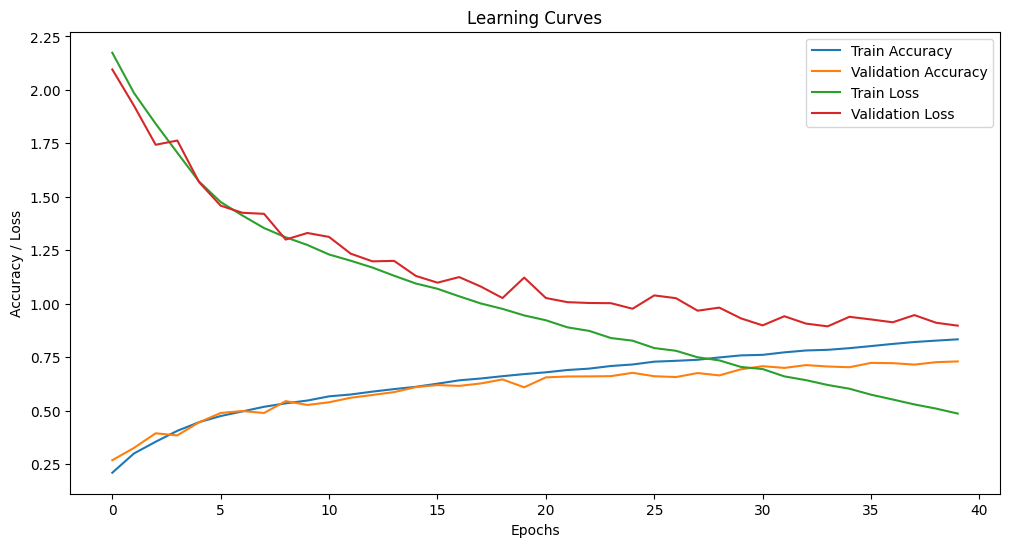

In [ ]:
plot_learning_curves(loaded_history_2)

Confusion matrix

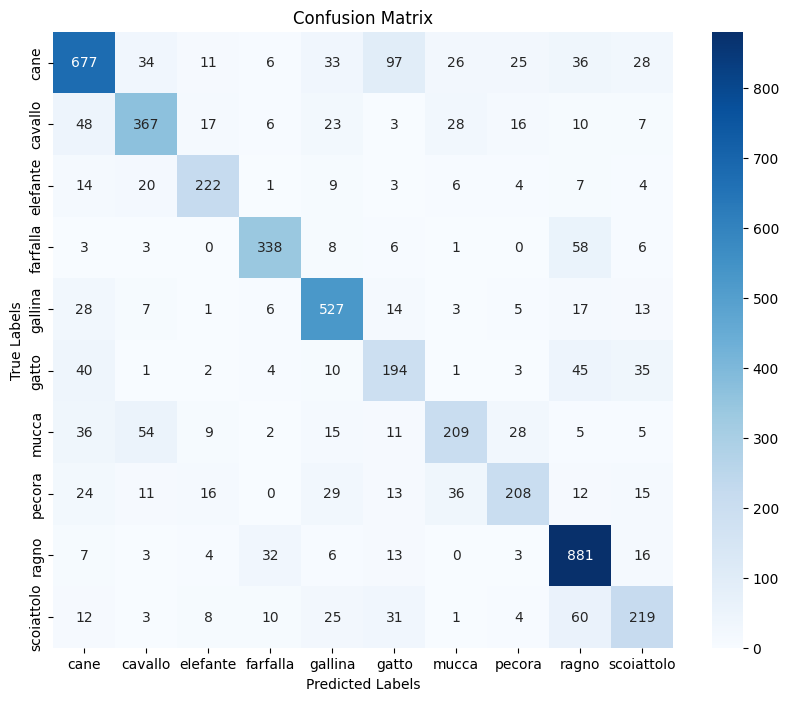

In [ ]:
class_labels = list(test_gen_2.class_indices.keys())
plot_confusion_matrix(y_true, y_pred_classes, class_labels)

ROC Curve

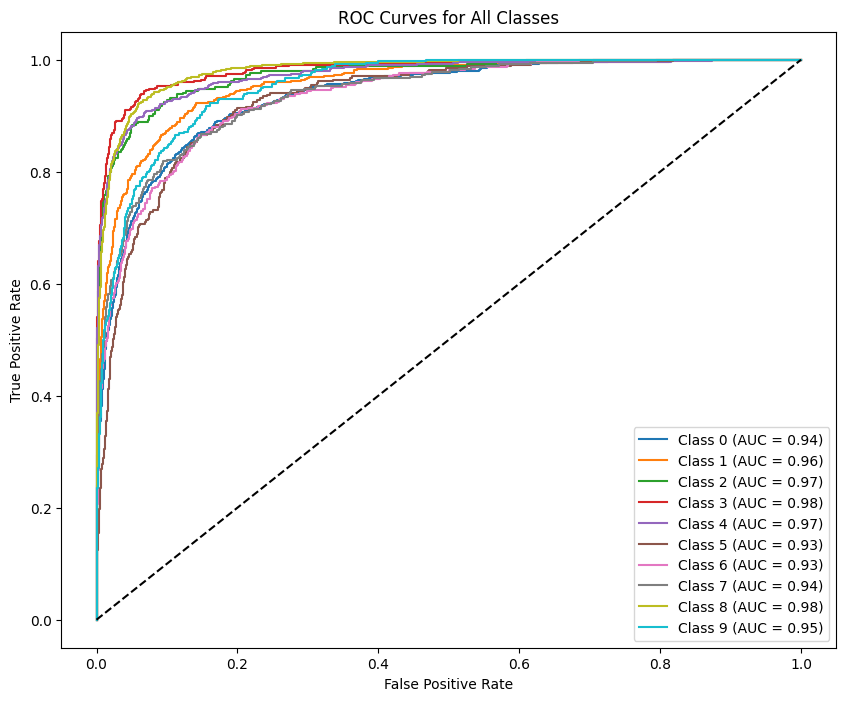

{'Class 0': 0.9355878027587967, 'Class 1': 0.9558343931044228, 'Class 2': 0.9733780293378449, 'Class 3': 0.9815774501437079, 'Class 4': 0.9726861171558555, 'Class 5': 0.9302448637010546, 'Class 6': 0.9341451922728425, 'Class 7': 0.9371881961039575, 'Class 8': 0.9803118497578889, 'Class 9': 0.9530005339910047}


In [ ]:
num_classes = 10
roc_auc_scores = plot_roc_curves(y_true, y_pred, num_classes)
print(roc_auc_scores)

Precision , recall , f1-score

In [ ]:
print(classification_report(y_true, y_pred_classes, target_names=test_gen_2.class_indices.keys()))

              precision    recall  f1-score   support

        cane       0.76      0.70      0.73       973
     cavallo       0.73      0.70      0.71       525
    elefante       0.77      0.77      0.77       290
    farfalla       0.83      0.80      0.82       423
     gallina       0.77      0.85      0.81       621
       gatto       0.50      0.58      0.54       335
       mucca       0.67      0.56      0.61       374
      pecora       0.70      0.57      0.63       364
       ragno       0.78      0.91      0.84       965
  scoiattolo       0.63      0.59      0.61       373

    accuracy                           0.73      5243
   macro avg       0.71      0.70      0.71      5243
weighted avg       0.73      0.73      0.73      5243



Visualize

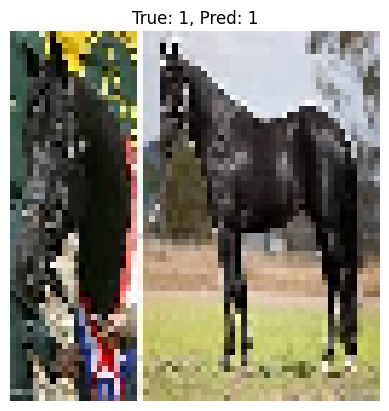

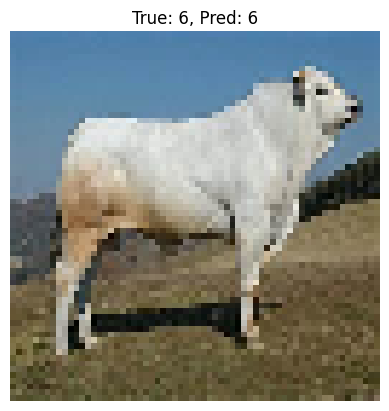

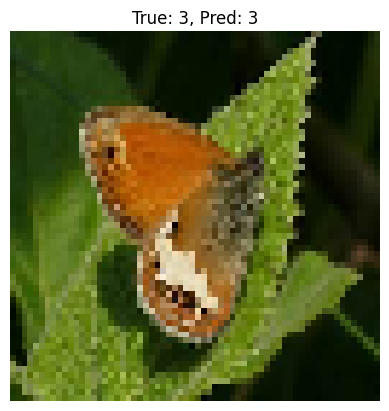

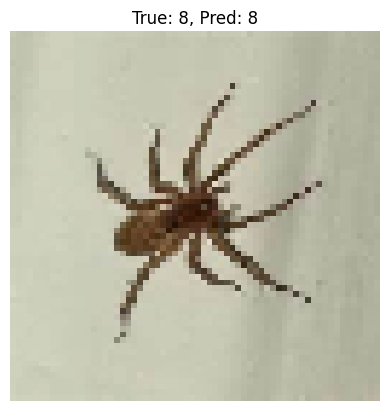

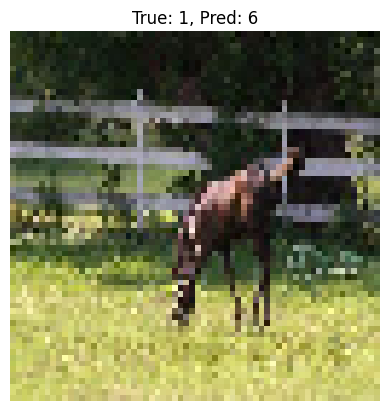

In [ ]:
visualize_random_predictions(test_gen_2, y_pred_classes, num_samples=5)

# Phase-3 (Overfitting Prevent)

# Model 1

batch_size=16 , learning_rate=0.00008 , epochs=60 , optimizer=RMSprop
Train Accuracy: 0.77 , Test Accuracy: 0.72

---


batch_size=16 , learning_rate=0.00008, epochs=60 , optimizer=adam
Train Accuracy: 0.82 , Test Accuracy: 0.76

---


batch_size=16 , learning_rate=0.00008, epochs=60 , optimizer=adam
Train Accuracy: 0.79  , Test Accuracy: 0.75

---


best -> batch_size=16 , learning_rate=0.00008 , epochs=60



Paths

In [12]:
train_path_3 = "animals_split/train"
val_path_3 = "animals_split/val"
test_path_3 = "animals_split/test"

data augmentation

In [13]:
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

Preprocessing

In [14]:
train_gen_3 = datagen.flow_from_directory(
    train_path_3, target_size=(64, 64), batch_size=16, class_mode='categorical'
)

val_gen_3 = datagen.flow_from_directory(
    val_path_3, target_size=(64, 64), batch_size=16, class_mode='categorical'
)

test_gen_3 = datagen.flow_from_directory(
    test_path_3, target_size=(64, 64), batch_size=16, class_mode='categorical', shuffle=False
)

Found 18322 images belonging to 10 classes.
Found 2614 images belonging to 10 classes.
Found 5243 images belonging to 10 classes.


CNN model

In [15]:
model_3 = Sequential([
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0001), input_shape=(64, 64, 3)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=l2(0.0001)),
    Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
    Dense(10, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Number of parameters

In [16]:
model_3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 62, 62, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 60, 60, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,294,474 (4.94 MB)

 Trainable params: 1,293,578 (4.93 MB)

 Non-trainable params: 896 (3.50 KB)

optimizers -> Adam

In [17]:
model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00008),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_3 = model_3.fit(
    train_gen_3,
    validation_data=val_gen_3,
    epochs=60,
)

optimizers-> RMSprop

In [ ]:
model_3.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00008),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_3 = model_3.fit(
    train_gen_3,
    validation_data=val_gen_3,
    epochs=60,
)

save model

In [ ]:
save_path = '/content/drive/MyDrive/project-4/Models/Phase3/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

model_3.save(os.path.join(save_path, 'best-adam-16-0.00008-60.h5'))

save history

In [ ]:
save_path = '/content/drive/MyDrive/project-4/Models/Phase3/'
history_path = os.path.join(save_path, 'history_best-adam-16-0.00008-60.pkl')
with open(history_path, 'wb') as f:
    pickle.dump(history_3.history, f)

load model

In [18]:
save_path = '/content/drive/MyDrive/project-4/Models/Phase3/'
loaded_model_3 = load_model(os.path.join(save_path, 'best-adam-16-0.00008-60.h5'))

load history

In [19]:
history_path_3 = os.path.join(save_path, 'history_best-adam-16-0.00008-60.pkl')
with open(history_path_3, 'rb') as f:
    loaded_history_3 = pickle.load(f)

In [20]:
train_loss, train_accuracy = loaded_model_3.evaluate(train_gen_3)
print(f"Train Accuracy: {train_accuracy:.2f}")

test_loss, test_accuracy = loaded_model_3.evaluate(test_gen_3)
print(f"Test Accuracy: {test_accuracy:.2f}")

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1146/1146 ━━━━━━━━━━━━━━━━━━━━ 80s 67ms/step - accuracy: 0.8209 - loss: 0.6487
Train Accuracy: 0.82
328/328 ━━━━━━━━━━━━━━━━━━━━ 23s 70ms/step - accuracy: 0.7046 - loss: 1.0005
Test Accuracy: 0.75


Evaluate model

Generate prediction

In [21]:
y_pred = loaded_model_3.predict(test_gen_3)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen_3.classes

328/328 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step


Learning Curves

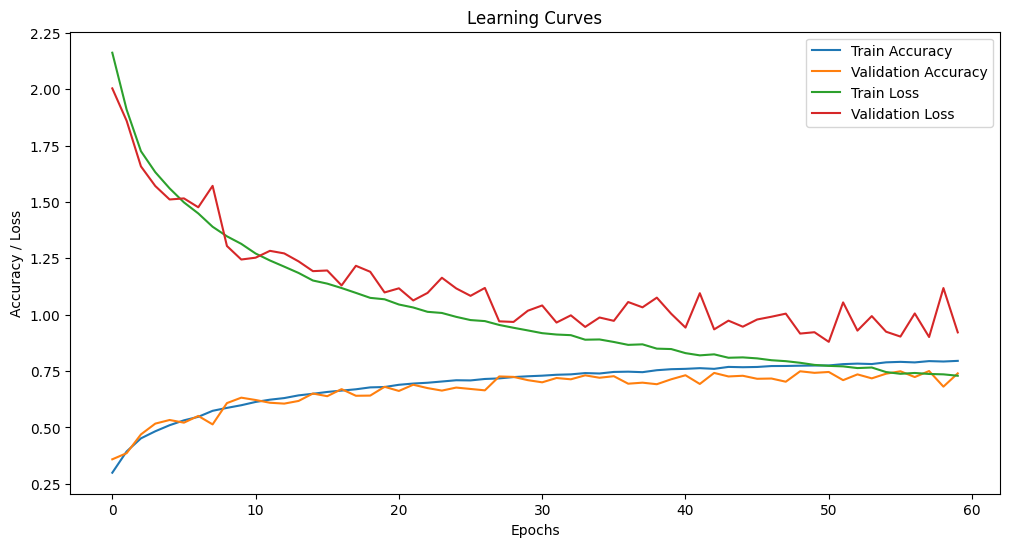

In [22]:
plot_learning_curves(loaded_history_3)

Confusion matrix

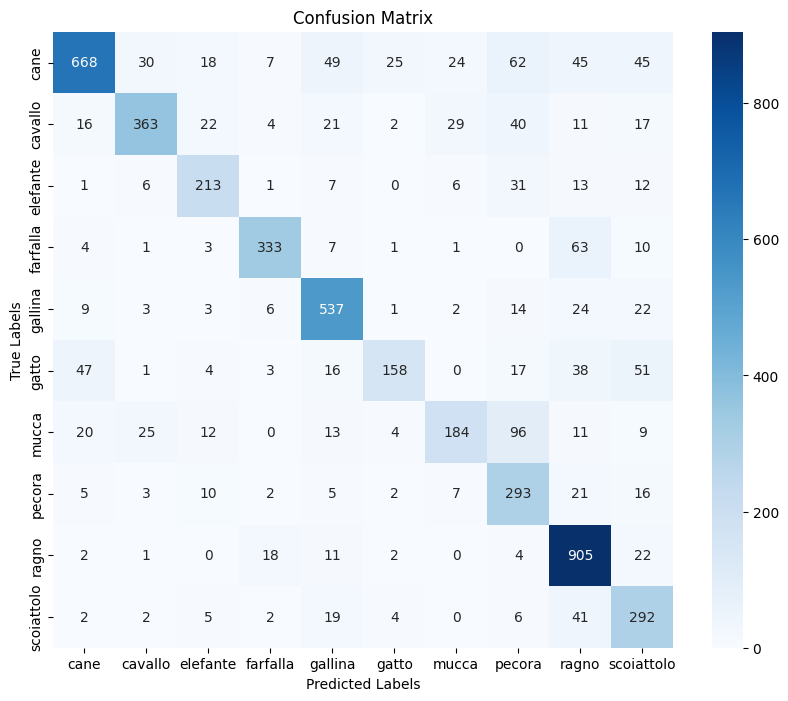

In [23]:
class_labels = list(test_gen_3.class_indices.keys())
plot_confusion_matrix(y_true, y_pred_classes, class_labels)

ROC Curve

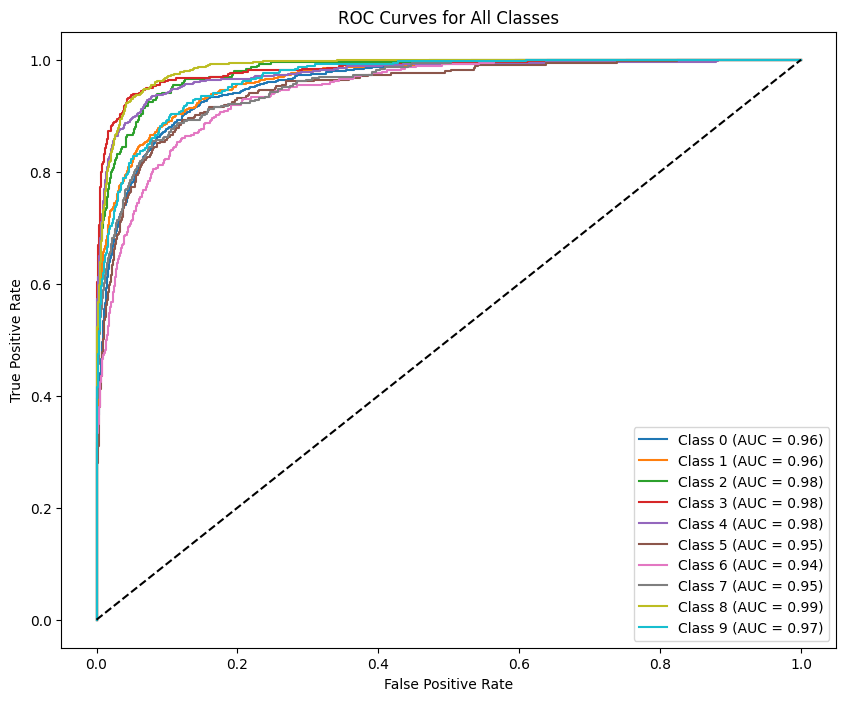

{'Class 0': 0.9576882622373163, 'Class 1': 0.9649718403681947, 'Class 2': 0.9796507863572756, 'Class 3': 0.9823783879226627, 'Class 4': 0.9756091952581334, 'Class 5': 0.9486613387828584, 'Class 6': 0.9440265435698729, 'Class 7': 0.9549589066395789, 'Class 8': 0.9857414849319448, 'Class 9': 0.9663514101216069}


In [24]:
num_classes = 10
roc_auc_scores = plot_roc_curves(y_true, y_pred, num_classes)
print(roc_auc_scores)

Precision , recall , f1-score

In [25]:
print(classification_report(y_true, y_pred_classes, target_names=test_gen_3.class_indices.keys()))

              precision    recall  f1-score   support

        cane       0.86      0.69      0.76       973
     cavallo       0.83      0.69      0.76       525
    elefante       0.73      0.73      0.73       290
    farfalla       0.89      0.79      0.83       423
     gallina       0.78      0.86      0.82       621
       gatto       0.79      0.47      0.59       335
       mucca       0.73      0.49      0.59       374
      pecora       0.52      0.80      0.63       364
       ragno       0.77      0.94      0.85       965
  scoiattolo       0.59      0.78      0.67       373

    accuracy                           0.75      5243
   macro avg       0.75      0.73      0.72      5243
weighted avg       0.77      0.75      0.75      5243



Visualize

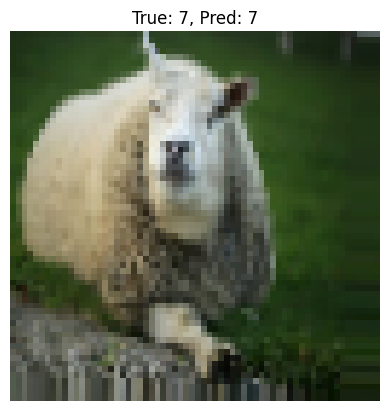

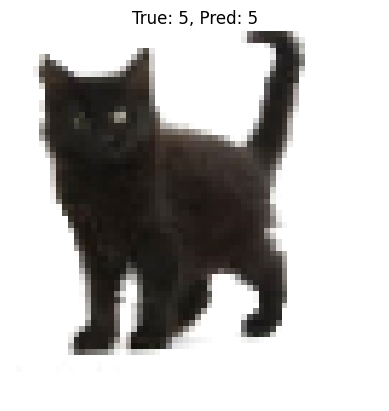

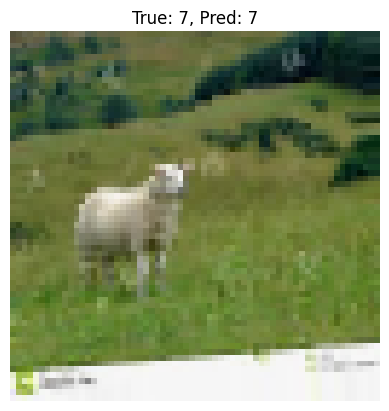

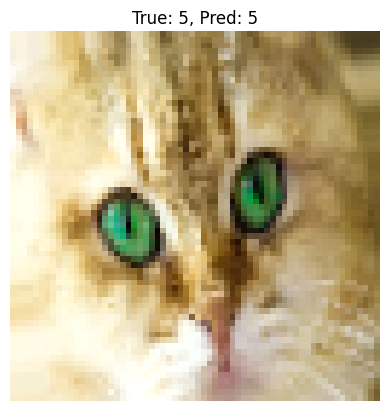

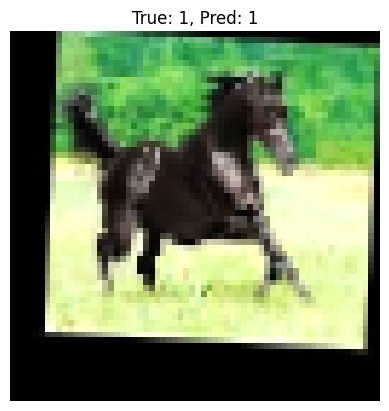

In [26]:
visualize_random_predictions(test_gen_3, y_pred_classes, num_samples=5)

# Model 2

batch_size=16 , learning_rate=0.00008 , epochs=60 , optimizer=RMSprop
Train Accuracy: 0.71 , Test Accuracy: 0.68

---


batch_size=16 , learning_rate=0.00008, epochs=60 , optimizer=adam
Train Accuracy: 0.76 , Test Accuracy: 0.72

---


batch_size=16 , learning_rate=0.00009, epochs=60 , optimizer=adam
Train Accuracy: 76 , Test Accuracy: 71

---


batch_size=16 , learning_rate=0.00008, epochs=100 , optimizer=adam
Train Accuracy: 79  , Test Accuracy: 74

---


best -> batch_size=16 , learning_rate=0.00008 , epochs=100



Paths

In [38]:
train_path_3 = "animals_split/train"
val_path_3 = "animals_split/val"
test_path_3 = "animals_split/test"

data augmentation

In [39]:
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

Preprocessing

In [40]:
train_gen_3 = datagen.flow_from_directory(
    train_path, target_size=(64, 64), batch_size=16, class_mode='categorical'
)

val_gen_3 = datagen.flow_from_directory(
    val_path, target_size=(64, 64), batch_size=16, class_mode='categorical'
)

test_gen_3 = datagen.flow_from_directory(
    test_path, target_size=(64, 64), batch_size=16, class_mode='categorical', shuffle=False
)

Found 18322 images belonging to 10 classes.
Found 2614 images belonging to 10 classes.
Found 5243 images belonging to 10 classes.


CNN model

In [41]:
model_3 = Sequential([
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0001), input_shape=(64, 64, 3)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    GlobalAveragePooling2D(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.0001)),
    Dense(16, activation='relu', kernel_regularizer=l2(0.0001)),
    Dense(10, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Number of parameters

In [42]:
model_3.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 62, 62, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 62, 62, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 60, 60, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │             170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 394,426 (1.50 MB)

 Trainable params: 393,530 (1.50 MB)

 Non-trainable params: 896 (3.50 KB)

optimizers -> Adam

In [43]:
model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00009),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_3 = model_3.fit(
    train_gen_3,
    validation_data=val_gen_3,
    epochs=60,
)

Epoch 1/60
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 86s 68ms/step - accuracy: 0.1829 - loss: 2.2732 - val_accuracy: 0.3106 - val_loss: 2.0958
Epoch 2/60
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 132s 63ms/step - accuracy: 0.2835 - loss: 2.0867 - val_accuracy: 0.3206 - val_loss: 1.9956
Epoch 3/60
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 73s 63ms/step - accuracy: 0.3356 - loss: 1.9676 - val_accuracy: 0.3152 - val_loss: 1.9348
Epoch 4/60
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 79s 60ms/step - accuracy: 0.3750 - loss: 1.8460 - val_accuracy: 0.4353 - val_loss: 1.6942
Epoch 5/60
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 73s 63ms/step - accuracy: 0.4019 - loss: 1.7819 - val_accuracy: 0.3929 - val_loss: 1.7411
Epoch 6/60
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 72s 63ms/step - accuracy: 0.4148 - loss: 1.7282 - val_accuracy: 0.4265 - val_loss: 1.6827
Epoch 7/60
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 74s 65ms/step - accuracy: 0.4276 - loss: 1.6703 - val_accuracy: 0.4434 - val_loss: 1.6162
Epoch 8/60
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 79s 62ms/step - accuracy: 0.4530 

optimizers-> RMSprop

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00008),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_3 = model_3.fit(
    train_gen_3,
    validation_data=val_gen_3,
    epochs=60,
)

Save model

In [ ]:
save_path = '/content/drive/MyDrive/project-4/Models/Phase3/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

model_3.save(os.path.join(save_path, 'best_model2_lr00008_phase3_adam_4Ov.h5'))

Save history

In [ ]:
save_path = '/content/drive/MyDrive/project-4/Models/Phase3/'
history_path_3 = os.path.join(save_path, 'best_history3_bs16_lr00008_phase3_adam_4Ov.pkl')
with open(history_path_3, 'wb') as f:
    pickle.dump(history_3.history, f)

Load model

In [44]:
save_path = '/content/drive/MyDrive/project-4/Models/Phase3/'
loaded_model_3 = load_model(os.path.join(save_path, 'best_model2_lr00008_phase3_adam_4Ov.h5'))

Load history

In [45]:
history_path_3 = os.path.join(save_path, 'best_history3_bs16_lr00008_phase3_adam_4Ov.pkl')
with open(history_path_3, 'rb') as f:
    loaded_history_3 = pickle.load(f)

Evaluate model

In [46]:
train_loss, train_accuracy = loaded_model_3.evaluate(train_gen_3)
print(f"Train Accuracy: {train_accuracy:.2f}")

test_loss, test_accuracy = loaded_model_3.evaluate(test_gen_3)
print(f"Test Accuracy: {test_accuracy:.2f}")

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1146/1146 ━━━━━━━━━━━━━━━━━━━━ 63s 54ms/step - accuracy: 0.7840 - loss: 0.7082
Train Accuracy: 0.79
328/328 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.7037 - loss: 0.9312
Test Accuracy: 0.74


Generate prediction

In [47]:
y_pred = loaded_model_3.predict(test_gen_3)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen_3.classes

328/328 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step


Learning Curves

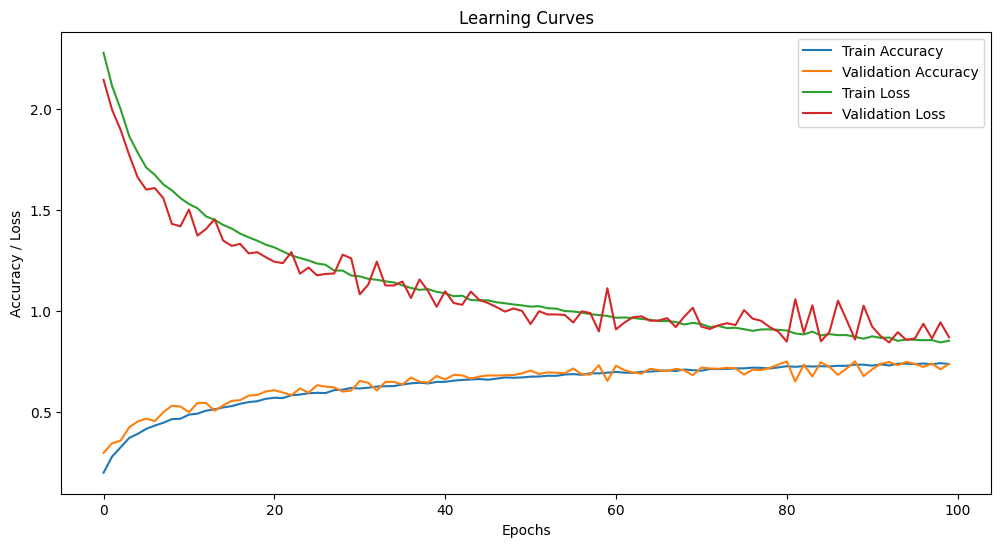

In [48]:
plot_learning_curves(loaded_history_3)

Confusion matrix

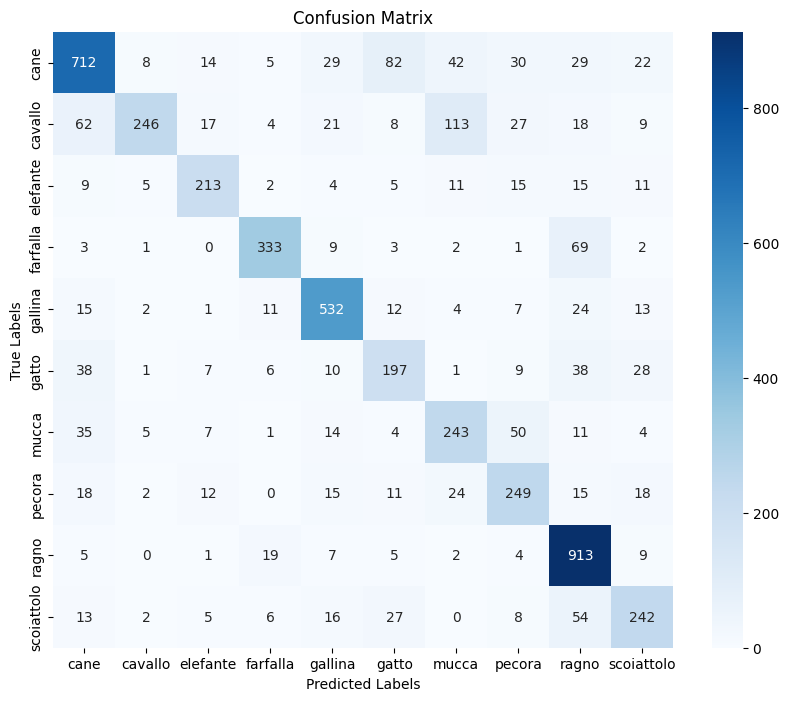

In [49]:
class_labels = list(test_gen_3.class_indices.keys())
plot_confusion_matrix(y_true, y_pred_classes, class_labels)

ROC Curve

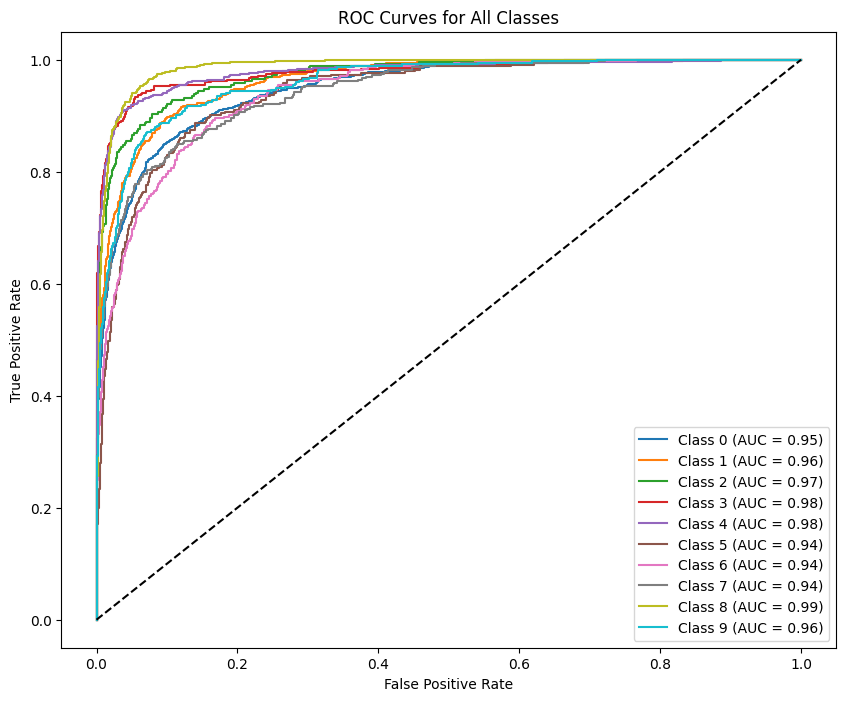

{'Class 0': 0.948685467818452, 'Class 1': 0.9635075395143221, 'Class 2': 0.9726658173033411, 'Class 3': 0.97778219200926, 'Class 4': 0.9779818009645114, 'Class 5': 0.941417606344804, 'Class 6': 0.9411775688822552, 'Class 7': 0.9438375725524731, 'Class 8': 0.9866975754977266, 'Class 9': 0.9593979664301324}


In [50]:
num_classes = 10
roc_auc_scores = plot_roc_curves(y_true, y_pred, num_classes)
print(roc_auc_scores)

Precision , recall , f1-score

In [51]:
print(classification_report(y_true, y_pred_classes, target_names=test_gen_3.class_indices.keys()))

              precision    recall  f1-score   support

        cane       0.78      0.73      0.76       973
     cavallo       0.90      0.47      0.62       525
    elefante       0.77      0.73      0.75       290
    farfalla       0.86      0.79      0.82       423
     gallina       0.81      0.86      0.83       621
       gatto       0.56      0.59      0.57       335
       mucca       0.55      0.65      0.60       374
      pecora       0.62      0.68      0.65       364
       ragno       0.77      0.95      0.85       965
  scoiattolo       0.68      0.65      0.66       373

    accuracy                           0.74      5243
   macro avg       0.73      0.71      0.71      5243
weighted avg       0.75      0.74      0.74      5243



Visualize

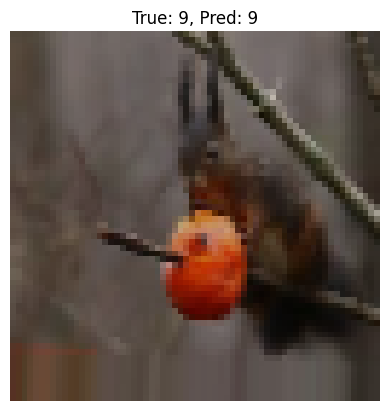

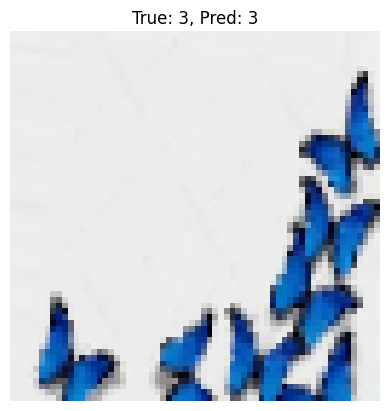

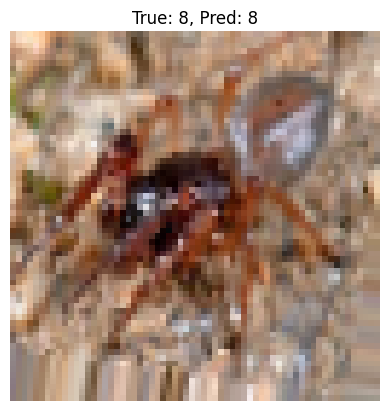

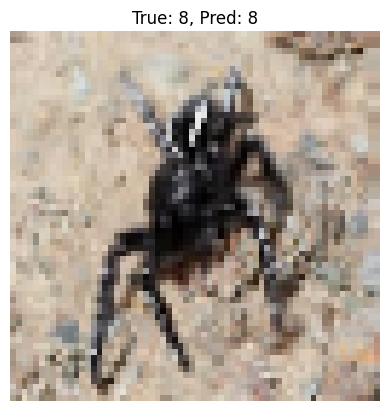

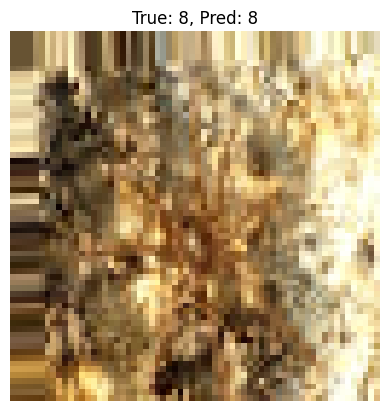

In [53]:
visualize_random_predictions(test_gen_3, y_pred_classes, num_samples=5)

# phase-4 (Transfer Learning)

# dataset 1

load

In [ ]:
!kaggle datasets download -d rafsunahmad/dog-sentiment-image-classification
!unzip dog-sentiment-image-classification.zip -d dog_sentiment

path

In [ ]:
dataset_path_new = "dog_sentiment"
output_folder_new = "dog_sentiment_split"

split

In [ ]:
import splitfolders
splitfolders.ratio(
    dataset_path_new,
    output=output_folder_new,
    seed=42,
    ratio=(0.7, 0.1, 0.2)
)

In [ ]:
train_path_new = os.path.join(output_folder_new, "train")
val_path_new = os.path.join(output_folder_new, "val")
test_path_new = os.path.join(output_folder_new, "test")

print(f"Number of train images: {count_images(train_path_new)}")
print(f"Number of validation images: {count_images(val_path_new)}")
print(f"Number of test images: {count_images(test_path_new)}")

data augmentation

In [ ]:
datagen_new = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

Preprocessing

In [ ]:
train_gen_new = datagen_new.flow_from_directory(
    train_path_new, target_size=(64, 64), batch_size=16, class_mode='categorical'
)
val_gen_new = datagen_new.flow_from_directory(
    val_path_new, target_size=(64, 64), batch_size=16, class_mode='categorical'
)
test_gen_new = datagen_new.flow_from_directory(
    test_path_new, target_size=(64, 64), batch_size=16, class_mode='categorical', shuffle=False
)

load trained model

In [ ]:
base_model = load_model('/content/drive/MyDrive/project-4/Models/Phase3/best-adam-16-0.00008-60.h5')

# part 1

freez model

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

new_model = Sequential(base_model.layers[:-1])
new_model.add(Dense(10, activation='softmax'))

compile model

In [ ]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

train new mode

In [ ]:
history_1_new = new_model.fit(
    train_gen_new,
    validation_data=val_gen_new,
    epochs=30,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

evaluate model

In [ ]:
train_loss_1_new, train_acc_1_new = new_model.evaluate(train_gen_new)
test_loss_1_new, test_acc_1_new = new_model.evaluate(test_gen_new)
print(f"First Phase - Train Accuracy: {train_acc_1_new:.2f}, Test Accuracy: {test_acc_1_new:.2f}")

save model

In [ ]:
model_save_path = '/content/drive/MyDrive/project-4/Models/Phase4/dog_sentiment_freeze.h5'
new_model.save(model_save_path)

save history

In [ ]:
history_save_path = '/content/drive/MyDrive/project-4/Models/Phase4/dog_sentiment_history.pkl'
with open(history_save_path, 'wb') as f:
    pickle.dump(history_1_new.history, f)

load model

In [ ]:
loaded_model = load_model(model_save_path)

load history

In [ ]:
with open(history_save_path, 'rb') as f:
    loaded_history = pickle.load(f)

Generate prediction

In [ ]:
y_pred = loaded_model.predict(test_gen_new)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen_new.classes

Learning Curves

In [ ]:
plot_learning_curves(loaded_history)

Confusion matrix

In [ ]:
class_labels = list(test_gen_new.class_indices.keys())
plot_confusion_matrix(y_true, y_pred_classes, class_labels)

ROC Curve

In [ ]:
num_classes = 10
roc_auc_scores = plot_roc_curves(y_true, y_pred, num_classes)
print(roc_auc_scores)

Precision , recall , f1-score

In [ ]:
print(classification_report(y_true, y_pred_classes, target_names=test_gen_new.class_indices.keys()))

Visualize

In [ ]:
visualize_random_predictions(test_gen_new, y_pred_classes, num_samples=5)

# part 2

unfreez

In [ ]:
model_unfreeze_new = tf.keras.models.load_model('/content/drive/MyDrive/project-4/Models/Phase4/dog_sentiment_freeze.h5')

for layer in model_unfreeze_new.layers[-10:]:
    layer.trainable = True

In [ ]:
model_unfreeze_new.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

tarin model

In [ ]:
history_2_new = model_unfreeze_new.fit(
    train_gen_new,
    validation_data=val_gen_new,
    epochs=30,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

evaluate model

In [ ]:
train_loss_2_new, train_acc_2_new = model_unfreeze_new.evaluate(train_gen_new)
test_loss_2_new, test_acc_2_new = model_unfreeze_new.evaluate(test_gen_new)

print(f"Second Phase - Train Accuracy: {train_acc_2_new:.2f}, Test Accuracy: {test_acc_2_new:.2f}")

save model

In [ ]:
model_save_path = '/content/drive/MyDrive/project-4/Models/Phase4/dog_sentiment_unfreeze.h5'
model_unfreeze_new.save(model_save_path)

save history

In [ ]:
history_save_path = '/content/drive/MyDrive/project-4/Models/Phase4/dog_sentiment_history_unfreeze.pkl'
with open(history_save_path, 'wb') as f:
    pickle.dump(history_2_new.history, f)

load model

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/project-4/Models/Phase4/dog_sentiment_unfreeze.h5')

load history

In [ ]:
with open('/content/drive/MyDrive/project-4/Models/Phase4/dog_sentiment_history_unfreeze.pkl', 'rb') as f:
    loaded_history = pickle.load(f)

Generate prediction

In [ ]:
y_pred = loaded_model.predict(test_gen_new)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen_new.classes

Learning Curves

In [ ]:
plot_learning_curves(loaded_history)

Confusion matrix

In [ ]:
class_labels = list(test_gen_new.class_indices.keys())
plot_confusion_matrix(y_true, y_pred_classes, class_labels)

ROC Curve

In [ ]:
num_classes = 10
roc_auc_scores = plot_roc_curves(y_true, y_pred, num_classes)
print(roc_auc_scores)

Precision , recall , f1-score

In [ ]:
print(classification_report(y_true, y_pred_classes, target_names=test_gen_new.class_indices.keys()))

Visualize

In [ ]:
visualize_random_predictions(test_gen_new, y_pred_classes, num_samples=5)

# dataset 2